# Notebook 02 (Light): Long-Term Simulation and Ruin Analysis

**Light version with reduced memory requirements**

This notebook performs Monte Carlo simulations to analyze:
- Ruin probabilities at different time horizons (10, 20, 50, 100 years)
- Impact of insurance deductibles and limits on survival
- Distribution of annualized returns (ROE) over long periods

**Note:** This light version reduces N_SIMULATIONS from 1000 to 100 and MAX_YEARS from 1000 to 100

In [1]:
# Setup and imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
import time
import psutil
import gc
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.claim_generator import ClaimGenerator

# Configure matplotlib for WSJ style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['grid.alpha'] = 0.3

# Set random seed
np.random.seed(42)

print(f"Available memory: {psutil.virtual_memory().available / 1e9:.1f} GB")
print("Running LIGHT version with reduced parameters")

Available memory: 0.7 GB
Running LIGHT version with reduced parameters


## 1. Simulation Parameters (Reduced for Memory)

In [2]:
# Simulation parameters - REDUCED FOR MEMORY
N_SIMULATIONS = 100  # Reduced from 1000
MAX_YEARS = 100      # Reduced from 1000
TIME_HORIZONS = [10, 20, 50, 100]  # Removed 500, 1000

# Insurance scenarios to test (keeping only 3 key scenarios)
insurance_scenarios = [
    {'name': 'No Insurance', 'deductible': float('inf'), 'limit': 0},
    {'name': 'Medium Coverage', 'deductible': 1_000_000, 'limit': 10_000_000},
    {'name': 'Full Coverage', 'deductible': 100_000, 'limit': 50_000_000},
]

# Claim parameters
claim_params = {
    'frequency': 0.1,  # Expected 1 claim every 10 years
    'severity_mean': 5_000_000,
    'severity_std': 3_000_000,
    'cat_frequency': 0.01,  # 1% chance per year of catastrophic event
    'cat_severity_mean': 25_000_000,
    'cat_severity_std': 10_000_000
}

print(f"Parameters for LIGHT version:")
print(f"  Simulations: {N_SIMULATIONS} (was 1000)")
print(f"  Max years: {MAX_YEARS} (was 1000)")
print(f"  Scenarios: {len(insurance_scenarios)} (was 5)")
print(f"  Total simulation-years: {N_SIMULATIONS * MAX_YEARS * len(insurance_scenarios):,} (was 5M)")
print(f"\nInsurance Scenarios:")
for scenario in insurance_scenarios:
    print(f"  {scenario['name']}: Deductible=${scenario['deductible']:,.0f}, Limit=${scenario['limit']:,.0f}")

Parameters for LIGHT version:
  Simulations: 100 (was 1000)
  Max years: 100 (was 1000)
  Scenarios: 3 (was 5)
  Total simulation-years: 30,000 (was 5M)

Insurance Scenarios:
  No Insurance: Deductible=$inf, Limit=$0
  Medium Coverage: Deductible=$1,000,000, Limit=$10,000,000
  Full Coverage: Deductible=$100,000, Limit=$50,000,000


## 2. Single Simulation Function

In [3]:
def run_single_simulation(params: Dict) -> Dict:
    """Run a single simulation with given parameters."""
    
    # Unpack parameters
    sim_id = params['sim_id']
    deductible = params['deductible']
    limit = params['limit']
    seed = params['seed']
    
    # Initialize manufacturer
    config = ManufacturerConfig(
        initial_assets=10_000_000,
        asset_turnover_ratio=1.0,
        base_operating_margin=0.08,
        tax_rate=0.25,
        retention_ratio=1.0
    )
    manufacturer = WidgetManufacturer(config)
    
    # Initialize claim generator
    claim_gen = ClaimGenerator(
        base_frequency=claim_params['frequency'],
        severity_mean=claim_params['severity_mean'],
        severity_std=claim_params['severity_std'],
        seed=seed
    )
    
    # Generate claims for entire period
    regular_claims = claim_gen.generate_claims(MAX_YEARS)
    cat_claims = claim_gen.generate_catastrophic_claims(
        MAX_YEARS,
        claim_params['cat_frequency'],
        claim_params['cat_severity_mean'],
        claim_params['cat_severity_std']
    )
    
    # Combine and sort claims
    all_claims = regular_claims + cat_claims
    claims_by_year = {}
    for claim in all_claims:
        if claim.year not in claims_by_year:
            claims_by_year[claim.year] = []
        claims_by_year[claim.year].append(claim.amount)
    
    # Track results
    ruin_year = None
    annual_returns = []
    
    # Run simulation
    for year in range(MAX_YEARS):
        # Process claims for this year
        if year in claims_by_year:
            for claim_amount in claims_by_year[year]:
                manufacturer.process_insurance_claim(claim_amount, deductible, limit)
        
        # Take annual step
        metrics = manufacturer.step(
            working_capital_pct=0.2,
            letter_of_credit_rate=0.015,
            growth_rate=0.03
        )
        
        # Record ROE
        annual_returns.append(metrics['roe'])
        
        # Check for ruin
        if manufacturer.is_ruined and ruin_year is None:
            ruin_year = year + 1
            break
    
    # Calculate annualized ROE
    if len(annual_returns) > 0:
        annualized_roe = np.mean(annual_returns)
    else:
        annualized_roe = 0
    
    return {
        'sim_id': sim_id,
        'ruin_year': ruin_year,
        'annualized_roe': annualized_roe,
        'final_equity': manufacturer.equity if not manufacturer.is_ruined else 0,
        'total_claims': sum(claim.amount for claim in all_claims)
    }

## 3. Run Simulations for Each Scenario

In [4]:
# Store results for all scenarios
scenario_results = {}

# Run simulations for each scenario
for scenario in insurance_scenarios:
    print(f"\nRunning {N_SIMULATIONS} simulations for: {scenario['name']}")
    print("=" * 50)
    
    # Prepare parameters
    sim_params = [
        {
            'sim_id': i,
            'deductible': scenario['deductible'],
            'limit': scenario['limit'],
            'seed': 42 + i  # Different seed for each simulation
        }
        for i in range(N_SIMULATIONS)
    ]
    
    # Track performance
    start_time = time.time()
    start_memory = psutil.Process().memory_info().rss / 1e9
    
    # Run simulations sequentially
    results = []
    for i, params in enumerate(sim_params):
        if i % 20 == 0:
            print(f"  Progress: {i}/{N_SIMULATIONS} simulations completed")
        results.append(run_single_simulation(params))
        
        # Garbage collection every 20 simulations to prevent memory buildup
        if i % 20 == 0:
            gc.collect()
    
    # Calculate metrics
    end_time = time.time()
    end_memory = psutil.Process().memory_info().rss / 1e9
    
    print(f"\n  Time taken: {end_time - start_time:.1f} seconds")
    print(f"  Memory used: {end_memory - start_memory:.1f} GB")
    print(f"  Simulations per second: {N_SIMULATIONS / (end_time - start_time):.1f}")
    
    # Store results
    scenario_results[scenario['name']] = pd.DataFrame(results)
    
    # Clean up memory
    gc.collect()

Company became insolvent - negative equity: $-21,697,426.07



Running 100 simulations for: No Insurance
  Progress: 0/100 simulations completed


Company became insolvent - negative equity: $-14,107,655.49
Company became insolvent - negative equity: $-1,610,174.62
Company became insolvent - negative equity: $-7,537,638.60
Company became insolvent - negative equity: $-1,131,635.13
Company became insolvent - negative equity: $-6,095,178.98
Company became insolvent - negative equity: $-242,983.94
Company became insolvent - negative equity: $-326,661.60
Company became insolvent - negative equity: $-6,161,549.90
Company became insolvent - negative equity: $-17,156,918.43
Company became insolvent - negative equity: $-563,119.58
Company became insolvent - negative equity: $-61,878.54
Company became insolvent - negative equity: $-4,039,602.67
Company became insolvent - negative equity: $-119,149,695.30
Company became insolvent - negative equity: $-21,080,862.62
Company became insolvent - negative equity: $-104,557.81
Company became insolvent - negative equity: $-489,378.95
Company became insolvent - negative equity: $-671,007.87


  Progress: 20/100 simulations completed


Company became insolvent - negative equity: $-1,451,166.66
Company became insolvent - negative equity: $-50,299,808.45
Company became insolvent - negative equity: $-2,274,103.24
Company became insolvent - negative equity: $-7,928,618.47
Company became insolvent - negative equity: $-4,252,799.18
Company became insolvent - negative equity: $-1,912,116.48
Company became insolvent - negative equity: $-581,708.00
Company became insolvent - negative equity: $-8,409,137.58
Company became insolvent - negative equity: $-723,813.29
Company became insolvent - negative equity: $-577,958.34
Company became insolvent - negative equity: $-342,807.33
Company became insolvent - negative equity: $-93,966,417.46


  Progress: 40/100 simulations completed


Company became insolvent - negative equity: $-1,720,340.13
Company became insolvent - negative equity: $-27,065.42
Company became insolvent - negative equity: $-37,007,241.44
Company became insolvent - negative equity: $-6,608,345.43
Company became insolvent - negative equity: $-1,036,654.65
Company became insolvent - negative equity: $-740,850.15
Company became insolvent - negative equity: $-10,108,691.95
Company became insolvent - negative equity: $-56,417,383.66
Company became insolvent - negative equity: $-254,370.23
Company became insolvent - negative equity: $-4,650,289.86
Company became insolvent - negative equity: $-49,393,348.50
Company became insolvent - negative equity: $-747,902.66
Company became insolvent - negative equity: $-2,579,376.81
Company became insolvent - negative equity: $-5,516,377.94
Company became insolvent - negative equity: $-1,555,418.47
Company became insolvent - negative equity: $-12,412,483.13


  Progress: 60/100 simulations completed


Company became insolvent - negative equity: $-5,547,707.81
Company became insolvent - negative equity: $-2,974,578.74
Company became insolvent - negative equity: $-3,452,879.57
Company became insolvent - negative equity: $-340,298.58
Company became insolvent - negative equity: $-1,307,892.24
Company became insolvent - negative equity: $-9,468,129.11
Company became insolvent - negative equity: $-12,737,452.90
Company became insolvent - negative equity: $-153,897.64
Company became insolvent - negative equity: $-1,170,444.91
Company became insolvent - negative equity: $-3,393,830.88
Company became insolvent - negative equity: $-15,403,987.34
Company became insolvent - negative equity: $-3,445,648.07
Company became insolvent - negative equity: $-4,129,646.69
Company became insolvent - negative equity: $-6,059,469.13
Company became insolvent - negative equity: $-118,042.16
Company became insolvent - negative equity: $-2,322,506.41
Company became insolvent - negative equity: $-12,990,722.35


  Progress: 80/100 simulations completed


Company became insolvent - negative equity: $-71,563,071.05
Company became insolvent - negative equity: $-13,898,372.82
Company became insolvent - negative equity: $-9,832,564.68
Company became insolvent - negative equity: $-512,749.24
Company became insolvent - negative equity: $-3,139,708.66
Company became insolvent - negative equity: $-1,294,442.19
Company became insolvent - negative equity: $-469,825.18
Company became insolvent - negative equity: $-6,646,748.45
Company became insolvent - negative equity: $-2,195,393.62
Company became insolvent - negative equity: $-13,652,145.88
Company became insolvent - negative equity: $-7,646,877.19
Company became insolvent - negative equity: $-4,264,723.51
Company became insolvent - negative equity: $-2,662,534.08
Company became insolvent - negative equity: $-5,943,778.43
Company became insolvent - negative equity: $-44,444,025.27
Company became insolvent - negative equity: $-64,233,455.05



  Time taken: 4.3 seconds
  Memory used: 0.0 GB
  Simulations per second: 23.5

Running 100 simulations for: Medium Coverage
  Progress: 0/100 simulations completed


Company became insolvent - negative equity: $-6,268,588.09
Company became insolvent - negative equity: $-1,671,221.56
Company became insolvent - negative equity: $-98,782,275.21


  Progress: 20/100 simulations completed


Company became insolvent - negative equity: $-17,478,766.40
Company became insolvent - negative equity: $-50,412,220.85
Company became insolvent - negative equity: $-63,201,649.99


  Progress: 40/100 simulations completed


Company became insolvent - negative equity: $-3,272,437.06
Company became insolvent - negative equity: $-16,576,821.57
Company became insolvent - negative equity: $-1,272,793.29
Company became insolvent - negative equity: $-9,256,030.06
Company became insolvent - negative equity: $-36,007,083.65
Company became insolvent - negative equity: $-28,989,521.19
Company became insolvent - negative equity: $-10,486,835.13


  Progress: 60/100 simulations completed


Company became insolvent - negative equity: $-10,881,600.34
Company became insolvent - negative equity: $-2,269,884.40
Company became insolvent - negative equity: $-538,658.36
Company became insolvent - negative equity: $-1,145,648.37
Company became insolvent - negative equity: $-45,893,666.93


  Progress: 80/100 simulations completed


Company became insolvent - negative equity: $-50,873,198.26
Company became insolvent - negative equity: $-14,485,787.33
Company became insolvent - negative equity: $-24,064,928.38
Company became insolvent - negative equity: $-37,609,779.14



  Time taken: 6.9 seconds
  Memory used: 0.0 GB
  Simulations per second: 14.5

Running 100 simulations for: Full Coverage
  Progress: 0/100 simulations completed


Company became insolvent - negative equity: $-17,312,594.84


  Progress: 20/100 simulations completed
  Progress: 40/100 simulations completed
  Progress: 60/100 simulations completed
  Progress: 80/100 simulations completed

  Time taken: 6.8 seconds
  Memory used: -0.0 GB
  Simulations per second: 14.7


## 4. Calculate Ruin Probabilities

In [5]:
# Calculate ruin probabilities
ruin_prob_data = []

for scenario_name, results_df in scenario_results.items():
    for horizon in TIME_HORIZONS:
        # Count simulations that failed by this horizon
        ruined = results_df['ruin_year'].notna() & (results_df['ruin_year'] <= horizon)
        ruin_prob = ruined.sum() / len(results_df)
        
        ruin_prob_data.append({
            'Scenario': scenario_name,
            'Horizon': horizon,
            'Ruin_Probability': ruin_prob * 100
        })

ruin_prob_df = pd.DataFrame(ruin_prob_data)

# Pivot for easier visualization
ruin_pivot = ruin_prob_df.pivot(index='Horizon', columns='Scenario', values='Ruin_Probability')

# Display table
print("\nRuin Probability by Time Horizon (%)")
print("=" * 60)
print(ruin_pivot.to_string(float_format='%.1f'))
print("\nNote: Based on", N_SIMULATIONS, "simulations (light version)")


Ruin Probability by Time Horizon (%)
Scenario  Full Coverage  Medium Coverage  No Insurance
Horizon                                               
10                  1.0              8.0          46.0
20                  1.0             17.0          64.0
50                  1.0             22.0          78.0
100                 1.0             22.0          79.0

Note: Based on 100 simulations (light version)


## 5. Visualize Results

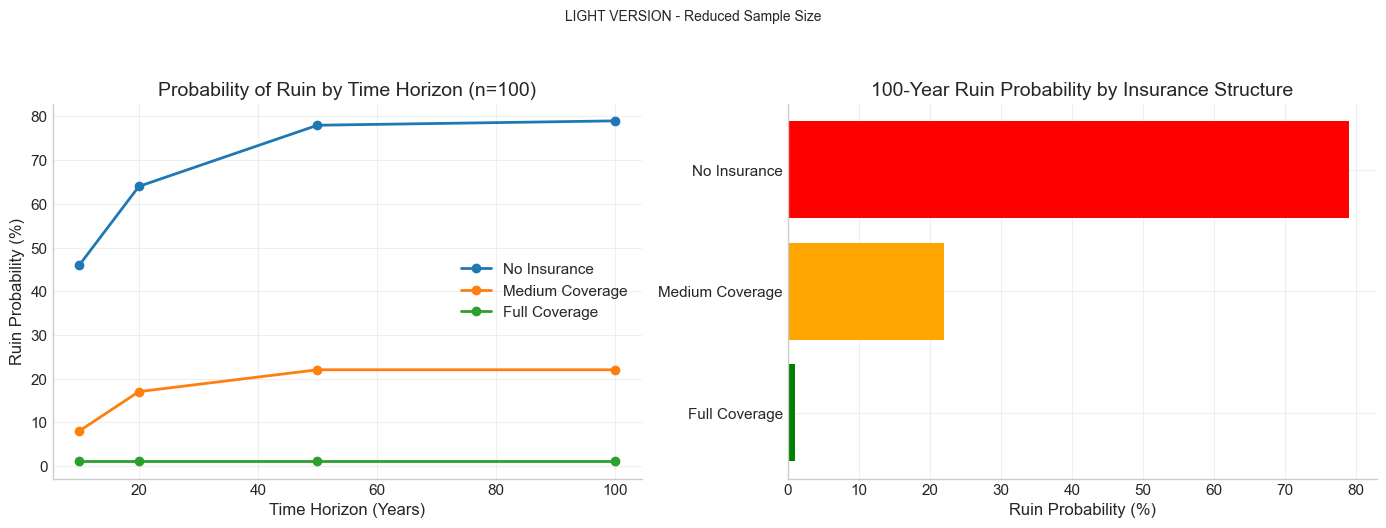

In [6]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Ruin probability curves
for scenario_name in scenario_results.keys():
    scenario_data = ruin_prob_df[ruin_prob_df['Scenario'] == scenario_name]
    ax1.plot(scenario_data['Horizon'], scenario_data['Ruin_Probability'], 
             marker='o', linewidth=2, label=scenario_name)

ax1.set_xlabel('Time Horizon (Years)')
ax1.set_ylabel('Ruin Probability (%)')
ax1.set_title(f'Probability of Ruin by Time Horizon (n={N_SIMULATIONS})')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Plot 2: Bar chart for 100-year horizon
horizon_100 = ruin_prob_df[ruin_prob_df['Horizon'] == 100].sort_values('Ruin_Probability')
colors = ['green' if x < 10 else 'orange' if x < 25 else 'red' 
          for x in horizon_100['Ruin_Probability']]

ax2.barh(range(len(horizon_100)), horizon_100['Ruin_Probability'], color=colors)
ax2.set_yticks(range(len(horizon_100)))
ax2.set_yticklabels(horizon_100['Scenario'])
ax2.set_xlabel('Ruin Probability (%)')
ax2.set_title('100-Year Ruin Probability by Insurance Structure')
ax2.grid(True, alpha=0.3, axis='x')

plt.suptitle('LIGHT VERSION - Reduced Sample Size', fontsize=10, y=1.05)
plt.tight_layout()
plt.show()

## Summary

This **light version** demonstrates the same analysis with reduced parameters:
- **100 simulations** instead of 1,000
- **100 years max** instead of 1,000
- **3 scenarios** instead of 5

Total simulation-years: **30,000** instead of 5,000,000

For full results, run the complete version with adequate memory (19+ GB RAM).